0 Route found: [2, 7, 5, 3, 1, 4, 0, 6]
Distance is 18.12899020449196
2 Route found: [0, 1, 3, 5, 2, 7, 4, 6]
Distance is 21.469413449533647

[[ 0.02141203  0.06384694 -0.09573769  0.11238414  0.08649893  0.00187622
  -0.05652667  0.08615341]
 [-0.0689022   0.05276357  0.0574208   0.04310018  0.03988475 -0.08760924
  -0.08498129  0.04812994]
 [-0.05149584  0.05811825 -0.01185345 -0.01246435  0.11804785  0.01612988
   0.10255932 -0.0461618 ]
 [-0.00310405  0.09186807  0.08469346  0.04644896  0.06822943  0.04351905
   0.0409602  -0.04405876]
 [-0.10754049  0.04664747  0.03295968  0.08301672  0.08709431  0.04444204
  -0.01404803  0.08092353]
 [ 0.09484878  0.01055431  0.11814439  0.10979914  0.0324727  -0.01316006
   0.11577108 -0.06590065]
 [ 0.10796363 -0.03313689  0.06398669  0.01887954  0.03598717  0.10184914
   0.06072957  0.10922918]
 [-0.06118704  0.12479208  0.03972215  0.07310711  0.06518275  0.11327929
  -0.08094297  0.05141896]]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.

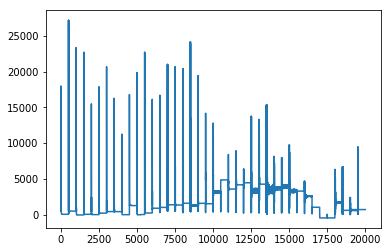

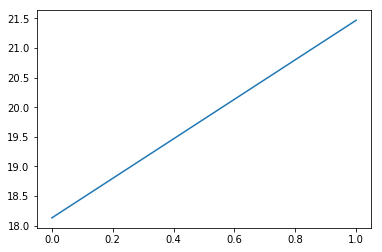

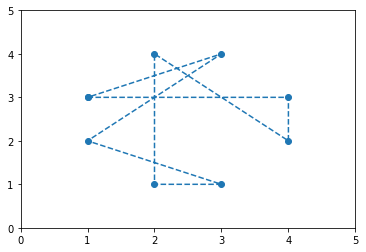

In [26]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  9 17:07:49 2016
This file is using the Hopfield Nerual Network to solve the TSP problem
@author: Hansyang
"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

def Distance(Data):
    N=len(Data)
    Dis=np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            Dis[i,j]=np.sqrt((Data[i,0]-Data[j,0])**2+(Data[i,1]-Data[j,1])**2)
    return Dis

def delta(i,j):
    if i==j:
        return 1
    else:
        return 0

def CalcuW(A,B,C,D,Dis):
    N=len(Dis)
    W=np.zeros([N,N,N,N]);
    for x in range(N):
        for i in range(N):
            for y in range(N):
                for j in range(N):
                    #W[x,i,y,j]=-A*delta(x,y)*(1-delta(i,j))-D*Dis[x,y]*delta(j,x+1)
                    W[x,i,y,j]=-A*delta(x,y)*(1-delta(i,j))-B*delta(i,j)*(1-delta(x,y))-C-D*Dis[x,y]*(delta(j,i+1)+delta(j,i-1))
    return W

def CalcuDeltaU(U,V,A,B,C,D,dis):
    N=len(V)
    deltaU=np.zeros([N,N])
    for x in range(N):
        for i in range(N):
            t1=0
            for j in range(N):
                if j!=i:
                    t1+=V[x,j]
            t1=A*t1
            t2=0
            for y in range(N):
                if y!=x:
                    t2+=V[y,i]
                    #t2 += V[x, y]
            t2=B*t2
            '''
            t3=0
            for j in range(N):
                for y in range(N):
                    t3+=V[j,y]
            t3=t3-N
            t3=C*t3
            '''
            t3 = 0
            for j in range(N):
                t3+=V[x,j]
            for y in range(N):
                t3 += V[y, i]
            t3 = t3 - 2*N
            t3 = C * t3

            t4=0
            for y in range(N):
                if y!=x:
                    i1=i+1
                    i2=i-1
                    if i1==N:
                        i1=0
                    if i2==-1:
                        i2=N-1
                    t4+=dis[x,y]*(V[y,i1]+V[y,i2])
            t4=D*t4
            deltaU[x,i]=-t1-t2-t3-t4#-U[x,i]
    return deltaU

def tanh(x):
    #print(x)
    if x>5:
        return 0.99995
    if x<-5:
        return -0.99995
    res=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return res

def CalcuV(U,U0):
    N=len(U)
    V=np.zeros([N,N])
    for x in range(N):
        for i in range(N):
            #print(U[x,i])
            V[x,i]=0.5*(1+tanh(U[x,i]/U0))
            if np.isnan(V[x,i]):
                #print(x,i)
                #print(U)
                break
    return V
def CalcuU(U,deltaU,step):
    for x in range(N):
        for i in range(N):
            U[x,i]+=deltaU[x,i]*step
    return U

def CacuEnergy( V,Dis,A,B,C,D,N):
    V=np.matrix(V)
    t1 = np.sum(np.power(np.sum(V, 1) - 1,2))
    t2 = np.sum(np.power(np.sum(V, 0) - 1,2))
    idx = [i for i in range(1, N)]
    idx = idx + [0]
    Vt = V[:, idx]
    t3 = Dis* Vt
    t3=np.sum(np.sum(np.multiply(V,t3)))
    E=0.5*(A*t1+B*t2+D*t3)
    return E

def isOK(V):
    N=len(V)
    NewV=np.zeros([N,N])
    Route=[]
    for i in range(N):
        mm=np.max(V[:,i])
        for j in range(N):
            if V[j,i]==mm:
                NewV[j,i]=1
                Route+=[j]
                break
    return Route,NewV

def CheckValue(V):
    N=len(V)
    for i in range(N):
        for j in range(N):
            if V[i,j]>0.3 and V[i,j]<0.7:
                return 0
    return 1

def CheckPosition(V):
    N=len(V)
    V1=np.zeros([N,N])
    for i in range(N):
        row_sum=0;
        clomn_sum=0;
        for j in range(N):
            if V[i,j]>=0.9:
                V1[i,j]=1
            if V[j,i]>=0.9:
                V1[j,i]=1
            row_sum+=V1[i,j]
            clomn_sum+=V1[j,i]
    if row_sum!=N:
        return 0
    if clomn_sum!=N:
        return 0
    return 1
def CalcuDis(Route,Dis):
    distance=0
    for i in range(N-1):
        distance+=Dis[Route[i],Route[i+1]]
    distance+=Dis[Route[N-1],Route[0]]
    return distance
def Plot(Route,Data):
    Route+=[Route[0]]
    Points=Data[Route,:]
    plt.figure(3)  
    plt.scatter(Points[:,0].tolist(),Points[:,1].tolist())
    plt.plot(Points[:,0],Points[:,1],linestyle="--")
    plt.xlim(0,5)
    plt.ylim(0,5)

# Data=np.random.rand(8,2)
Data=np.matrix([[1,2],[2,1],[1,3],[2,4],[3,1],[4,2],[3,4],[4,3]]);
Dis=Distance(Data)
N=len(Dis)
A=N*N
D=N/2
U0=0.0009
step=0.0001
B=N*N
C=N/4
#COUNT
maxecho=40

W=CalcuW(A,B,C,D,Dis)
U=0.002*(2*np.random.rand(N,N)-1)

V=1/N*(2*np.random.rand(N,N)-1)
Dis_best=np.sum(Dis)
Route_final="No answear"
E_all=[]
Dis_all=[]
Route_all=[]
for r in tqdm_notebook(range(maxecho)):
    count=0
    flag=1
    while count<500:
        #print(r*1000+count)S
        E_all+=[CacuEnergy( V,Dis,A,B,C,D,N)]
        count+=1
        deltaU=CalcuDeltaU(U,V,A,B,C,D,Dis)
        U=CalcuU(U,deltaU,step)
        V=CalcuV(U,U0)
    Route, NewV = isOK(V)
    #print(r)
    #print(NewV)
    #print(Route)
    if len(np.unique(Route))==8:
        print(r,"Route found:",Route)
        Dis_r=CalcuDis(Route,Dis)
        Dis_all+=[Dis_r]
        Route_all+=[Route]
        print("Distance is",Dis_r)
        #Plot(Route,Data)
        if Dis_r<Dis_best:
            Dis_best=Dis_r
            Route_final=Route
    #V=V+2*(2*np.random.rand(N,N)-1)
    U=0.002*(2*np.random.rand(N,N)-1)
    V= 1 / N * (2 * np.random.rand(N, N) - 1)
    A+=10*(2*np.random.rand(1,1)-1)
    B=A
    C+=10*(2*np.random.rand(1,1)-1)
    D+=10*(2*np.random.rand(1,1)-1)

plt.figure(1)
plt.plot(E_all)
plt.figure(2)
plt.plot(Dis_all)
if Route_final!="No answear":
    Plot(Route_final,Data)
print(V)
Route,NewV=isOK(V)
print(NewV)
#plt.show()
print("The final best Route is :",Route_final)
print("The distance of the Route is:",Dis_best) 

array([[0.62119081]])